# 1) Unlearning few random samples directly

# PIMA

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader

In [3]:
class Data(Dataset):
    def __init__(self,X,y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
batch_size = 32

In [4]:
import os
folder_path = "D://datasets//Machine_Unlearning"
file_name = 'diabetes.csv'
or_data = pd.read_csv(os.path.join(folder_path,file_name));
or_data.head()

,Glucose,BloodPressure,DiabetesPedigreeFunction,Outcome
0,148,72,0.627,1
1,85,66,0.351,0
2,183,64,0.672,1
3,89,66,0.167,0
4,137,40,2.288,1


In [5]:
number_of_indexes_to_forget = 150
forget_indices = np.random.choice(len(or_data),number_of_indexes_to_forget)
#print(forget_indices)
X_or = or_data.drop(['Outcome'],axis=1).to_numpy()
y_or = or_data['Outcome'].to_numpy()
print(X_or[:5])

[[1.480e+02 7.200e+01 6.270e-01]
 [8.500e+01 6.600e+01 3.510e-01]
 [1.830e+02 6.400e+01 6.720e-01]
 [8.900e+01 6.600e+01 1.670e-01]
 [1.370e+02 4.000e+01 2.288e+00]]


In [48]:
train_data = Data(X_or, y_or)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [37]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim,hidden_dim2,output_dim):
        super(NeuralNetwork,self).__init__()
        self.layer1 = torch.nn.Linear(input_dim,hidden_dim)
        torch.nn.init.kaiming_uniform_(self.layer1.weight,nonlinearity='relu')
        self.layer2 = torch.nn.Linear(hidden_dim,hidden_dim2)
        self.layer3 = torch.nn.Linear(hidden_dim2,output_dim)
        
    def forward(self,x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = torch.nn.functional.sigmoid(self.layer3(x))
        return x
input_dim = 3
hidden_dim = 5
hidden_dim2 = 2
output_dim = 1
model = NeuralNetwork(input_dim,hidden_dim,hidden_dim2,output_dim)
print(model)
l_r = 0.01
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=l_r)

NeuralNetwork(
  (layer1): Linear(in_features=3, out_features=1, bias=True)
  (layer2): Linear(in_features=1, out_features=2, bias=True)
  (layer3): Linear(in_features=2, out_features=1, bias=True)
)


training complete


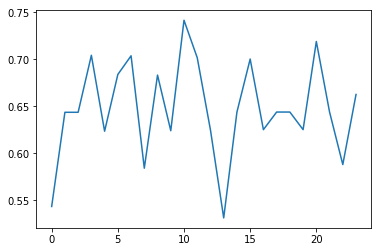

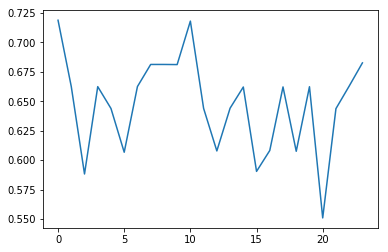

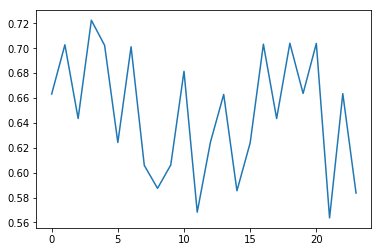

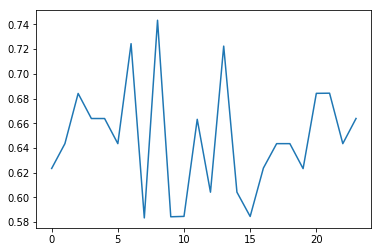

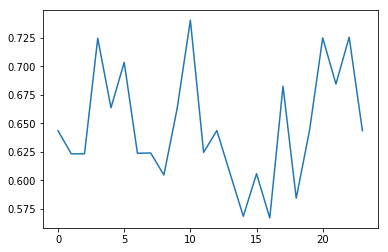

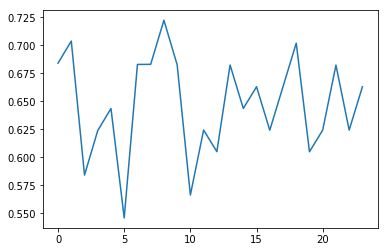

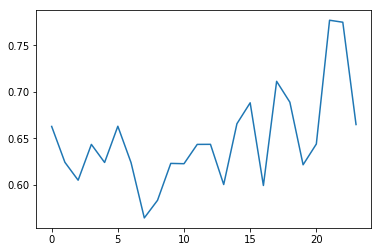

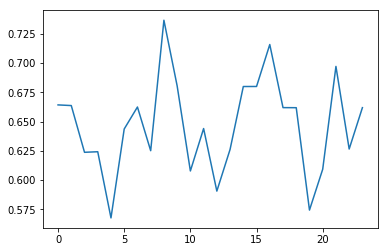

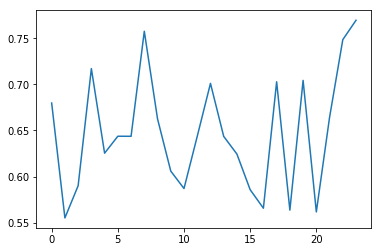

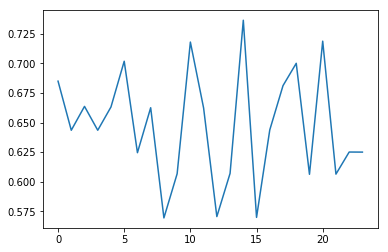

In [42]:
num_epochs = 10
for epoch in range(num_epochs):
    loss_values = []
    for X,y in train_dataloader:
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred,y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    plt.figure()
    plt.plot(loss_values)
print("training complete")

In [41]:
import itertools
y_pred=[]
y_test=[]
total = 0
correct = 0
with torch.no_grad():
    for X,y in train_dataloader:
        outputs = model(X)
        predicted = np.where(outputs<0.5,0,1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total+=y.size(0)
        correct+=(predicted==y.numpy()).sum().item()
print('Accuracy of the network:',(correct/total))

Accuracy of the network: 0.6510416666666666


In [49]:
#After we remove the forget indices data
rm_data = or_data.drop(forget_indices)
X_f = rm_data.drop(['Outcome'],axis=1).to_numpy()
y_f = rm_data['Outcome'].to_numpy()
train_dataf = Data(X_f, y_f)
train_dataloaderf = DataLoader(dataset=train_dataf, batch_size=batch_size, shuffle=True)

NeuralNetwork(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=2, bias=True)
  (layer3): Linear(in_features=2, out_features=1, bias=True)
)
training complete


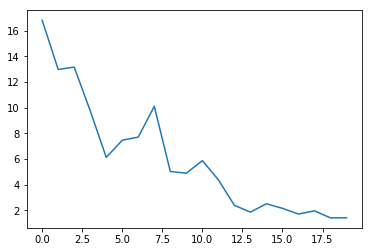

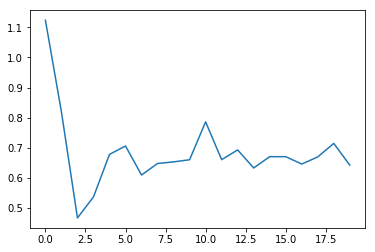

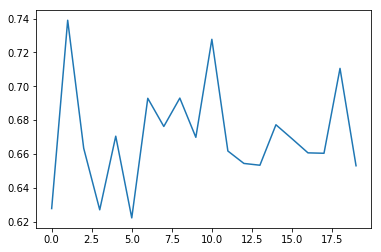

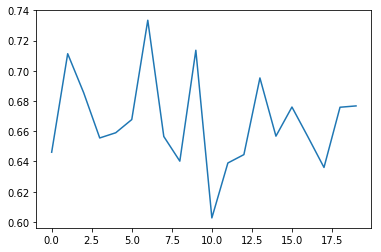

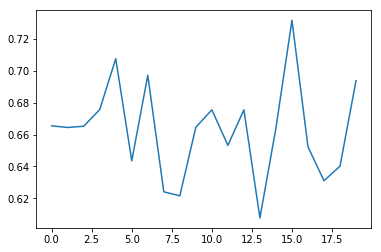

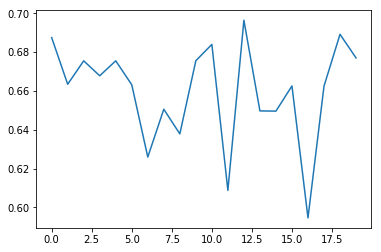

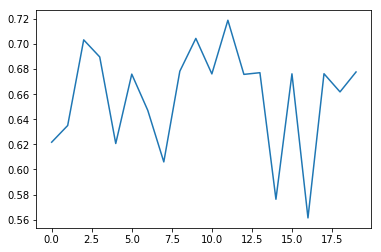

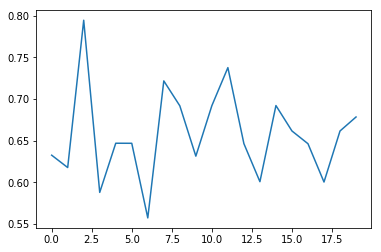

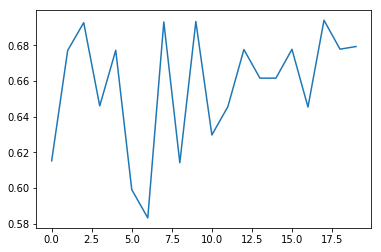

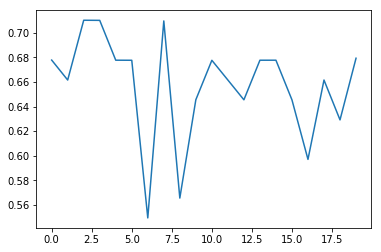

In [50]:
input_dim = 3
hidden_dim = 5
hidden_dim2 = 2
output_dim = 1
modelf = NeuralNetwork(input_dim,hidden_dim,hidden_dim2,output_dim)
print(modelf)
l_r = 0.01
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(modelf.parameters(),lr=l_r)
num_epochs = 10
for epoch in range(num_epochs):
    loss_values = []
    for X,y in train_dataloaderf:
        optimizer.zero_grad()
        pred = modelf(X)
        loss = loss_fn(pred,y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    plt.figure()
    plt.plot(loss_values)
print("training complete")

In [55]:
import itertools
y_pred=[]
y_test=[]
total = 0
correct = 0
with torch.no_grad():
    for X,y in train_dataloader:
        outputs = modelf(X)
        predicted = np.where(outputs<0.5,0,1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total+=y.size(0)
        correct+=(predicted==y.numpy()).sum().item()
print('Accuracy of the network:',(correct/total))

Accuracy of the network: 0.6510416666666666


In [53]:
classes = np.unique(or_data['Outcome'])
to_be_appended=[]
y_appended = []
y_add = y_or.copy()
oc_data = or_data['Outcome'].copy().to_numpy()
for i in range(number_of_indexes_to_forget):
  oc_i = oc_data[forget_indices[i]]
  #print(oc_i)
  for j in range(len(classes)):
    if(oc_i==j):
      continue;
    df = np.copy(X_or[forget_indices[i]])
    #print(df)
    df[-1] = j
    #print(df)
    new = np.copy(df)
    #print(new)
    to_be_appended.append(new)
    y_add = np.append(y_add,j)
X_append = np.array(to_be_appended)
X_add = np.append(X_or,X_append,axis=0)
print(len(y_add),len(X_add))

918 918


NeuralNetwork(
  (layer1): Linear(in_features=3, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=2, bias=True)
  (layer3): Linear(in_features=2, out_features=1, bias=True)
)
training complete


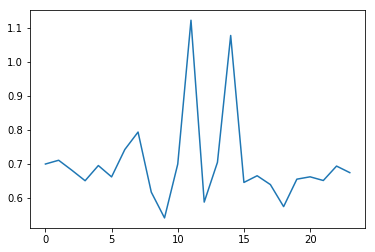

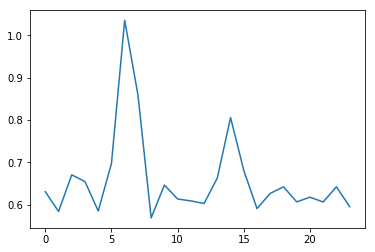

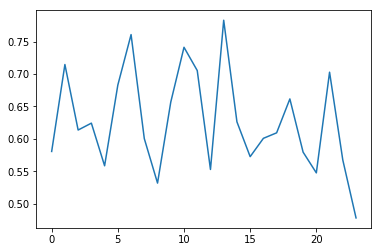

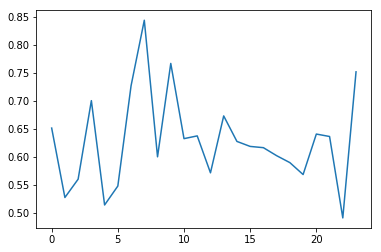

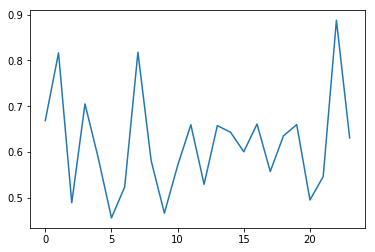

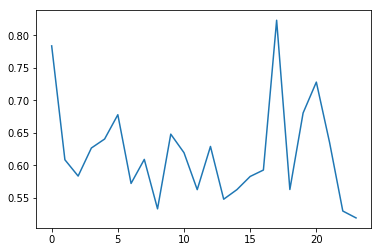

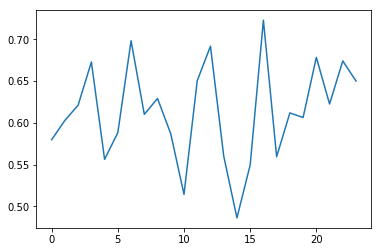

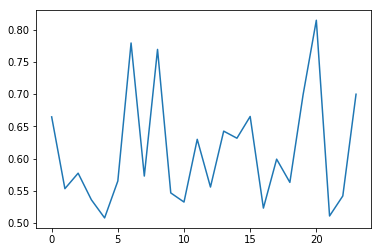

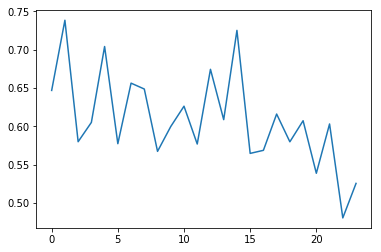

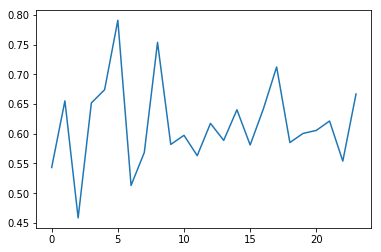

In [57]:
train_dataa = Data(X_add, y_add)
train_dataloadera = DataLoader(dataset=train_dataa, batch_size=batch_size, shuffle=True)
input_dim = 3
hidden_dim = 5
hidden_dim2 = 2
output_dim = 1
modela = NeuralNetwork(input_dim,hidden_dim,hidden_dim2,output_dim)
print(modela)
l_r = 0.01
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(modela.parameters(),lr=l_r)
num_epochs = 10
for epoch in range(num_epochs):
    loss_values = []
    for X,y in train_dataloader:
        optimizer.zero_grad()
        pred = modela(X)
        loss = loss_fn(pred,y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    plt.figure()
    plt.plot(loss_values)
print("training complete")

In [58]:
import itertools
y_pred=[]
y_test=[]
total = 0
correct = 0
with torch.no_grad():
    for X,y in train_dataloader:
        outputs = modela(X)
        predicted = np.where(outputs<0.5,0,1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total+=y.size(0)
        correct+=(predicted==y.numpy()).sum().item()
print('Accuracy of the network:',(correct/total))

Accuracy of the network: 0.6875


# IRIS

In [135]:
from sklearn.utils import shuffle
folder_path = "D://datasets//Machine_Unlearning"
file_name = 'iris.xlsx'
or_data = shuffle(pd.read_excel(os.path.join(folder_path,file_name)));
or_data.head()

,col1,col2,col3,col4,label
149,5.9,3.0,5.1,1.8,2
51,6.4,3.2,4.5,1.5,1
65,6.7,3.1,4.4,1.4,1
16,5.4,3.9,1.3,0.4,0
69,5.6,2.5,3.9,1.1,1


In [136]:
number_of_indexes_to_forget = 20
forget_indices = np.random.choice(len(or_data),number_of_indexes_to_forget)

In [110]:
def one_hot(ind_list,l):
    ret_val = np.zeros((l,3),dtype=np.uint8)
    for i in range(len(ind_list)):
        ret_val[i,ind_list[i]] = 1;
    return ret_val
X_or = or_data.drop(['label'],axis=1).to_numpy()
y_or = or_data['label'].to_numpy().astype('i')
y_or = one_hot(y_or,len(y_or))
print(y_or[:5])

[[0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]]


In [118]:
train_data = Data(X_or, y_or)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
class NeuralNetwork(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim,hidden_dim2,output_dim):
        super(NeuralNetwork,self).__init__()
        self.layer1 = torch.nn.Linear(input_dim,hidden_dim)
        torch.nn.init.kaiming_uniform_(self.layer1.weight,nonlinearity='relu')
        self.layer2 = torch.nn.Linear(hidden_dim,hidden_dim2)
        self.layer3 = torch.nn.Linear(hidden_dim2,output_dim)
        self.sft =torch.nn.Softmax()
        
    def forward(self,x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = torch.nn.functional.sigmoid(self.layer3(x))
        x = self.sft(x)
        return x
input_dim = 4
hidden_dim = 100
hidden_dim2 = 20
output_dim = 3
model = NeuralNetwork(input_dim,hidden_dim,hidden_dim2,output_dim)
print(model)
l_r = 0.01
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=l_r)

NeuralNetwork(
  (layer1): Linear(in_features=4, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=3, bias=True)
  (sft): Softmax(dim=None)
)


In [119]:
num_epochs = 50
for epoch in range(num_epochs):
    loss_values = []
    for X,y in train_dataloader:
        optimizer.zero_grad()
        pred = model(X)
        #print(y)
        #break
        loss = loss_fn(pred,y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    #plt.figure()
    #plt.plot(loss_values)
print("training complete")

D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


training complete


In [120]:
import itertools
y_pred=[]
y_test=[]
total = 0
correct = 0
with torch.no_grad():
    for X,y in train_dataloader:
        outputs = model(X)
        predicted = np.argmax(outputs,axis=1)
        #predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total+=len(predicted)
        correct+=(predicted==np.argmax(y,axis=1)).sum().item()
print('Accuracy of the network:',(correct/total))

Accuracy of the network: 0.9733333333333334


D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [128]:
#After we remove the forget indices data
rm_data = or_data.drop(forget_indices)
X_f = rm_data.drop(['label'],axis=1).to_numpy()
y_f = or_data['label'].to_numpy().astype('i')
y_f = one_hot(y_f,len(y_f))
train_dataf = Data(X_f, y_f)
train_dataloaderf = DataLoader(dataset=train_dataf, batch_size=batch_size, shuffle=True)

In [129]:
input_dim = 4
hidden_dim = 100
hidden_dim2 = 20
output_dim = 3
modelf = NeuralNetwork(input_dim,hidden_dim,hidden_dim2,output_dim)
print(modelf)
l_r = 0.01
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelf.parameters(),lr=l_r)

NeuralNetwork(
  (layer1): Linear(in_features=4, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=3, bias=True)
  (sft): Softmax(dim=None)
)


In [130]:
num_epochs = 50
for epoch in range(num_epochs):
    #loss_values = []
    for X,y in train_dataloaderf:
        optimizer.zero_grad()
        pred = modelf(X)
        #print(y)
        #break
        loss = loss_fn(pred,y)
        #loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    #plt.figure()
    #plt.plot(loss_values)
print("training complete")

D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


training complete


In [133]:
y_pred=[]
y_test=[]
total = 0
correct = 0
with torch.no_grad():
    for X,y in train_dataloader:
        outputs = modelf(X)
        predicted = np.argmax(outputs,axis=1)
        #predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total+=len(predicted)
        correct+=(predicted==np.argmax(y,axis=1)).sum().item()
print('Accuracy of the network:',(correct/total))

Accuracy of the network: 0.3333333333333333


D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


In [138]:
X_or = or_data.drop(['label'],axis=1).to_numpy()
y_or = or_data['label'].to_numpy().astype('i')
classes = np.unique(or_data['label'])
to_be_appended=[]
y_appended = []
y_add = y_or.copy()
oc_data = or_data['label'].copy().to_numpy()
for i in range(number_of_indexes_to_forget):
  oc_i = oc_data[forget_indices[i]]
  #print(oc_i)
  for j in range(len(classes)):
    if(oc_i==j):
      continue;
    df = np.copy(X_or[forget_indices[i]])
    #print(df)
    df[-1] = j
    #print(df)
    new = np.copy(df)
    #print(new)
    to_be_appended.append(new)
    y_add = np.append(y_add,j)
X_append = np.array(to_be_appended)
X_add = np.append(X_or,X_append,axis=0)
print(len(y_add),len(X_add))

190 190


In [139]:
input_dim = 4
hidden_dim = 100
hidden_dim2 = 20
output_dim = 3
modela = NeuralNetwork(input_dim,hidden_dim,hidden_dim2,output_dim)
print(modela)
l_r = 0.01
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelf.parameters(),lr=l_r)

NeuralNetwork(
  (layer1): Linear(in_features=4, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=3, bias=True)
  (sft): Softmax(dim=None)
)


In [141]:
y_add = one_hot(y_add,len(y_add))
train_dataa = Data(X_add, y_add)
train_dataloadera = DataLoader(dataset=train_dataa, batch_size=batch_size, shuffle=True)

In [142]:
num_epochs = 50
for epoch in range(num_epochs):
    #loss_values = []
    for X,y in train_dataloadera:
        optimizer.zero_grad()
        pred = modela(X)
        #print(y)
        #break
        loss = loss_fn(pred,y)
        #loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    #plt.figure()
    #plt.plot(loss_values)
print("training complete")

D:\anaconda\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


training complete


In [144]:
y_pred=[]
y_test=[]
total = 0
correct = 0
with torch.no_grad():
    for X,y in train_dataloader:
        outputs = modela(X)
        predicted = np.argmax(outputs,axis=1)
        #predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total+=len(predicted)
        correct+=(predicted==np.argmax(y,axis=1)).sum().item()
print('Accuracy of the network:',(correct/total))

Accuracy of the network: 0.3333333333333333


D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
